## Load the SVHN dataset

In [ ]:
#import wget
#train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
#test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

#train_data = wget.download(train_url)
#test_data = wget.download(test_url)

In [2]:
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"

--2024-01-22 10:48:08--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  15.3MB/s    in 27s     

2024-01-22 10:48:35 (6.48 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-01-22 10:48:35--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  5.06MB/s    in 11s     

2024-01-22 10:48:46 (5.68 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [3]:
from scipy.io import loadmat
data_train = loadmat('/content/train_32x32.mat')
data_test = loadmat('/content/test_32x32.mat')

## EDA

In [ ]:
type(data_train), type(data_test)

(dict, dict)

In [ ]:
# a dic has three attributes: .items() / .keys() / .values()
data_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [ ]:
data_test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
X_train = data_train['X']
X_test = data_test['X']

y_train = data_train['y']
y_test = data_test['y']

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X_train.shape

(32, 32, 3, 73257)

In [5]:
# pip install matplotlib
import matplotlib.pyplot as plt

def image_viz(X, y):
    fig, axes = plt.subplots(2, 5, figsize=(12,6))
    # flatten the axes array for easy indexing
    axes = axes.ravel()
    for i in range(10):
        img = X[:, :, :, i]
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off') # remove the ticks on axis
    plt.tight_layout()
    plt.show()

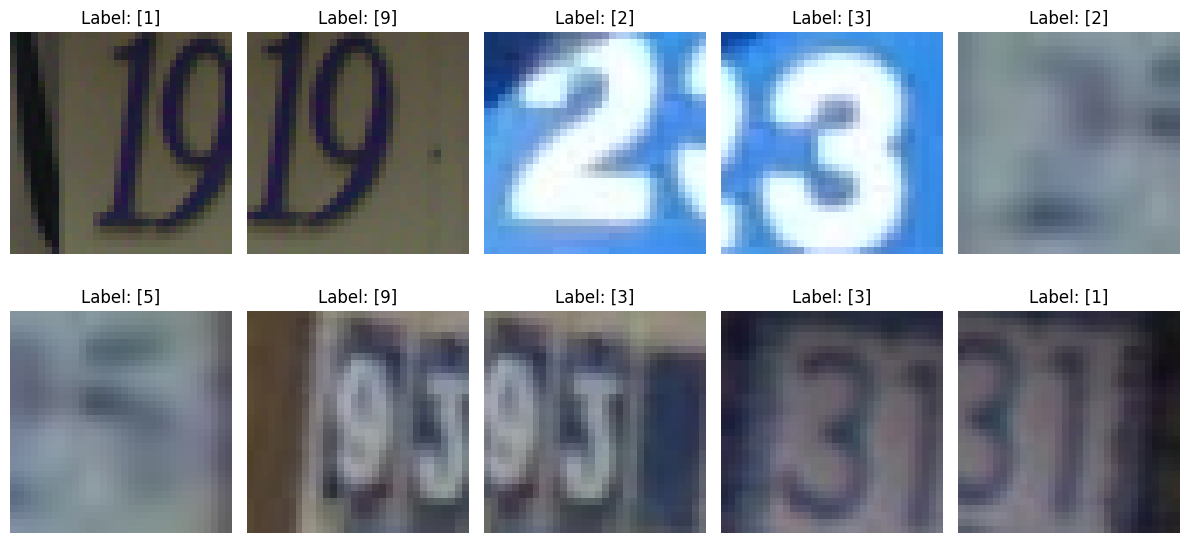

In [ ]:
image_viz(X_train, y_train)

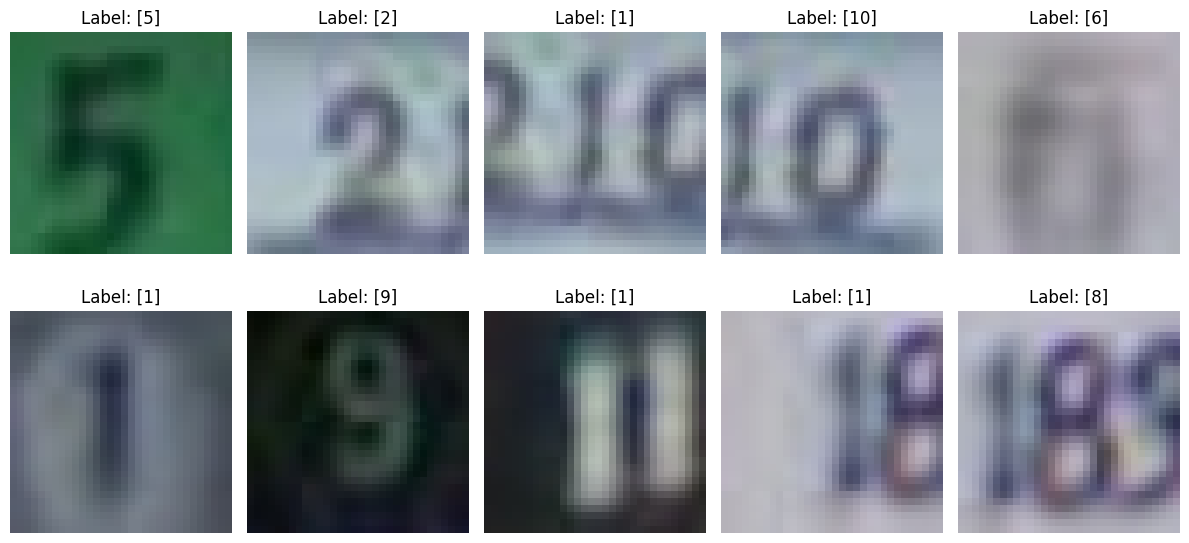

In [ ]:
image_viz(X_test, y_test)

In [6]:
# check the y distribution (to see if the dataset is imbalance)
import numpy as np
def label_dist(y):
    unique_labels, counts = np.unique(y, return_counts=True)
    return dict(zip(unique_labels, counts))

In [ ]:
train_dist = label_dist(y_train)
test_dist = label_dist(y_test)

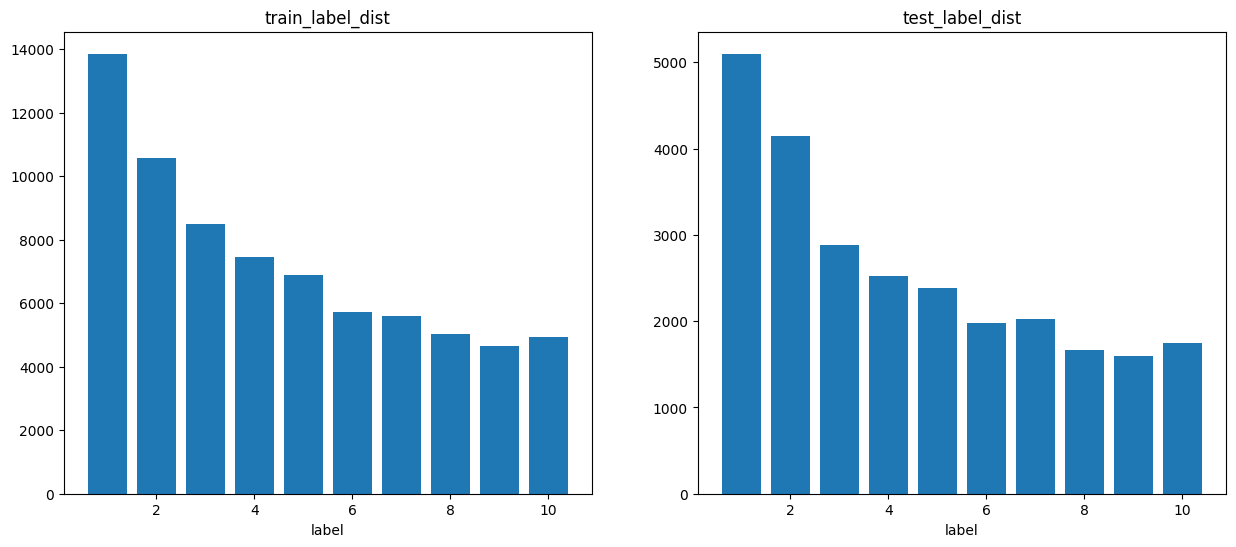

In [ ]:
plt.figure(figsize=(15,6), dpi=100)
plt.subplot(1, 2, 1)
plt.bar(train_dist.keys(), train_dist.values())
plt.title("train_label_dist")
plt.xlabel("label")
plt.subplot(1, 2, 2)
plt.bar(test_dist.keys(), test_dist.values())
plt.title("test_label_dist")
plt.xlabel("label");

In [ ]:
X_train.min(), X_train.max()

(0, 255)

## Preprcessing

In [7]:
## Normalization
def normalizer(X):
    X = X / 255
    return X

In [8]:
X_train_norm = normalizer(X_train)
X_test_norm = normalizer(X_test)

In [ ]:
np.shape(X_train_norm)

(32, 32, 3, 73257)

In [9]:
# gray_scale
def convert_gray(X):
    return np.mean(X, axis=2, keepdims=True)

In [10]:
X_train_norm_gray = convert_gray(X_train_norm)
X_test_norm_gray = convert_gray(X_test_norm)
np.shape(X_train_norm_gray)
np.shape(X_test_norm_gray)

(32, 32, 1, 26032)

In [11]:
# reshape to prepare the inputs for ML models
def reshape(X):
    return X.transpose(3, 0, 1, 2).reshape(np.shape(X)[3], -1)

X_tr = reshape(X_train_norm_gray)
X_ts = reshape(X_test_norm_gray)

X_tr_rgb = reshape(X_train_norm)
X_ts_rgb = reshape(X_test_norm)

In [ ]:
X_tr.shape, X_tr_rgb.shape

((73257, 1024), (73257, 3072))

In [12]:
y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

In [13]:
#imbalance handling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_tr, y_train = sm.fit_resample(X_tr, y_train)
X_ts, y_test = sm.fit_resample(X_ts, y_test)

In [ ]:
from collections import Counter
Counter(y_train),Counter(y_test)

(Counter({1: 13861,
          9: 13861,
          2: 13861,
          3: 13861,
          5: 13861,
          8: 13861,
          7: 13861,
          4: 13861,
          6: 13861,
          0: 13861}),
 Counter({5: 5099,
          2: 5099,
          1: 5099,
          0: 5099,
          6: 5099,
          9: 5099,
          8: 5099,
          3: 5099,
          4: 5099,
          7: 5099}))

In [ ]:
# Train Phase
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=20, n_estimators=100)
rf_clf.fit(X_tr, y_train)

RandomForestClassifier(max_depth=20)

In [ ]:
# Test phase
from sklearn.metrics import accuracy_score
y_pred = rf_clf.predict(X_ts)
accuracy_score(y_test, y_pred)

0.7224553834085115

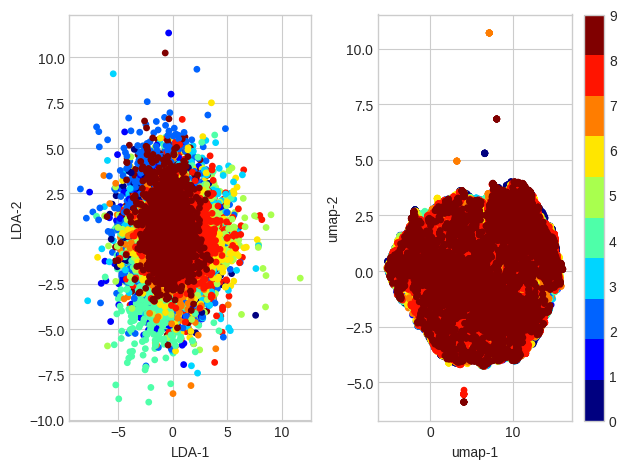

In [ ]:
# different models (clf, dim reduction)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_tr, y_train)
X_tr_lda = lda.transform(X_tr)
X_ts_lda = lda.transform(X_ts)


!pip install umap_learn
from umap import UMAP
ump = UMAP(n_components=2)
X_tr_umap = ump.fit_transform(X_tr)
X_ts_umap = ump.transform(X_ts)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (15,6))
c_map = plt.cm.get_cmap('jet', 10)


plt.subplot(1, 2, 1)
plt.scatter(X_tr_lda[:, 0], X_tr_lda[:, 1], s = 15, cmap = c_map , c = y_train)
plt.xlabel('LDA-1') , plt.ylabel('LDA-2')

plt.subplot(1, 2, 2)
plt.scatter(X_tr_umap[:, 0], X_tr_umap[:, 1], s = 15, cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('umap-1') , plt.ylabel('umap-2')

plt.tight_layout()
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_tr_umap, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 138610, number of used features: 2
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


LGBMClassifier()

In [ ]:

y_pred = lgbm_clf.predict(X_ts_umap)
accuracy_score(y_test, y_pred)

0.18093743871347323

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_tr)
# transform
X_tr_pca = pca.transform(X_tr)
X_ts_pca = pca.transform(X_ts)

In [ ]:
variances = pca.explained_variance_ratio_
variances

array([6.06703902e-01, 5.97587652e-02, 4.87212300e-02, ...,
       4.43992325e-08, 4.25845412e-08, 4.20103008e-08])

In [ ]:
cum_variances = np.cumsum(variances)
# cumulative percentage of compnents' importance
cum_variances

array([0.6067039 , 0.66646267, 0.7151839 , ..., 0.99999992, 0.99999996,
       1.        ])

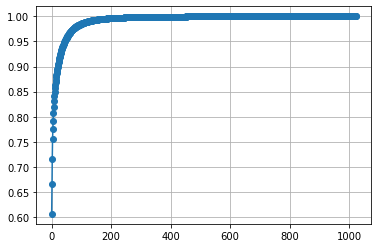

In [ ]:
plt.plot(cum_variances, marker='o')
plt.grid()

In [16]:
component_90 = np.argmax(cum_variances > 0.9) + 1
#pca_90 = PCA(n_components=component_90)

pca_95 = PCA(n_components=0.95)
X_tr_95 = pca_95.fit_transform(X_tr)
X_ts_95 = pca_95.transform(X_ts)

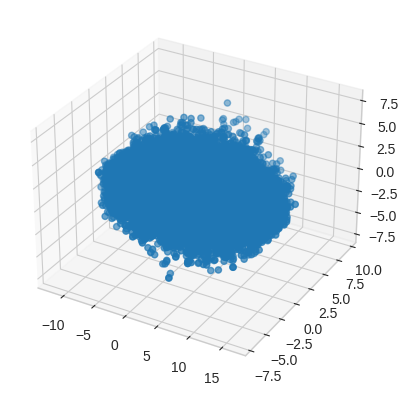

In [ ]:
#Viz 3 random featuers after pca
ax = plt.axes(projection='3d')
ax.scatter3D(X_tr_95[:,0], X_tr_95[:,1], X_tr_95[:,2])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=20, n_estimators=100)
rf_clf.fit(X_tr_95, y_train)

In [ ]:
# Test phase
from sklearn.metrics import accuracy_score
y_pred = rf_clf.predict(X_ts_95)
accuracy_score(y_test, y_pred)

0.6180470190534727

In [18]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=200)
xgb_clf.fit(X_tr_95, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [21]:
y_pred = xgb_clf.predict(X_ts_95)
accuracy_score(y_test, y_pred)

0.7366150225534418

In [ ]:
# hyperparameter tunning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
h_pars = {'kernel':['linear', 'rbf'], 'C':[0.01, 0.1, 1, 100, np.inf]}
svc = SVC()
rand_search = RandomizedSearchCV(svc, h_pars, cv=4)
rand_search.fit(X_tr_lda[:10000,:], y_train[:10000])
print(rand_search.best_params_)
rand_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_v

{'kernel': 'rbf', 'C': 1}


0.2327

In [ ]:
# imbalance handling
# hyperparameter tunning
# experiment 3-ch
# different models (clf, dim reduction)
# NNs
# Viz 2d after pca
# deployment